# LSS applied to CA-backbone of BBA fast-folding protein


## Load the different components from their respective repos

In [1]:
from mdn_propagator.propagator import Propagator
from molgen.models import DDPM
from snrv import Snrv

### Other dependencies

In [2]:
import mdtraj as md
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
import glob
import nglview as nv
import random

import seaborn as sns
from scipy.stats import pearsonr

# Load 10 DESRES trajectories for training

In [3]:
# load DESRES trajectories
load_path = '/project/andrewferguson/DESRES/DESRES-Trajectory_1FME-0-c-alpha/1FME-0-c-alpha'
trj_fnames = sorted(glob.glob(f'{load_path}/1FME-0-c-alpha-00*.dcd'))
top_fname = f'{load_path}/1FME-0-c-alpha.pdb'
save_freq = 200 # ps

In [4]:
# center frames and superpose each frame on reference
trjs = [md.load(t, top=top_fname).center_coordinates() for t in trj_fnames]
ref_frame = trjs[0][0]
trjs = [t.superpose(ref_frame, 0) for t in trjs]

print(len(trjs), trjs[0].xyz.shape)

10 (100000, 28, 3)


In [5]:
# view an example trj

v = nv.show_mdtraj(trjs[3])
v.clear_representations()
v.add_representation('ball+stick')
v

NGLWidget(max_frame=99999)

In [6]:
# extract all (inverse) distances between CA as features -- 28 residues == 378 featurse

coords_torch = list()
for trj in trjs:
    pdists = [torch.pdist(p)[None] for p in torch.tensor(trj.xyz)]
    coords_torch.append(torch.cat(pdists))
len(coords_torch), coords_torch[0].shape

(10, torch.Size([100000, 378]))

In [7]:
# extract some physically relevant features -- probably don't need this?

ref_trj = trjs[0]

h2t_list = []
rmsd_list = []

for trj in trjs:
    h2t = md.compute_distances(trj, [[0, 27]])[:, 0]
    h2t_list.append(h2t)
    
    rmsd = md.rmsd(trj, ref_trj, 0)
    rmsd_list.append(rmsd)
    
h2t_list = np.concatenate(h2t_list)
rmsd_list = np.concatenate(rmsd_list)

In [8]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# SRV fitting

In [9]:
from snrv.utils import set_random_seed

In [10]:
set_random_seed(42)

Setting random seed to 42


In [11]:
# train for 3 epochs (1_000_000 frames each) to avoid overfitting

input_size = coords_torch[0].size()[1]
output_size = 7
hidden_depth = 2
hidden_size = 100
batch_norm = True
dropout_rate = 0.0
lr = 1E-2
weight_decay = 0.0
val_frac = 0.05
n_epochs = 3
batch_size = 25000
VAMPdegree = 2
is_reversible = True
num_workers = 0

model_snrv = Snrv(input_size, output_size, hidden_depth=hidden_depth, hidden_size=hidden_size,
            batch_norm=batch_norm, dropout_rate=dropout_rate, lr=lr, weight_decay=weight_decay, 
            val_frac=val_frac, n_epochs=n_epochs, batch_size=batch_size, 
            VAMPdegree=VAMPdegree,is_reversible=is_reversible, num_workers=num_workers,
            activation=torch.nn.GELU(), device=device)

model_snrv = model_snrv.to(device)

In [12]:
lag_n = 50  # (10 ns)  selected based on previous hyperparam check

load_pretrained_snrv = True
save_new_model = False
model_save_path = './collab_files/model_snrv-3.pth'

if load_pretrained_snrv:
    ckp = torch.load(model_save_path)
    model_snrv.load_state_dict(ckp['model_state_dict'])
    model_snrv.training_losses = ckp['training_losses']
    model_snrv.validation_losses = ckp['validation_losses']
    model_snrv.evals = ckp['evals']
    model_snrv.expansion_coefficients = ckp['expansion_coefficients']
    model_snrv.is_fitted = True
    
else:
    model_snrv.fit(coords_torch, lag=lag_n, scheduler=0.98)
    if save_new_model:
        torch.save(model_snrv.state_dict(), model_save_path)
        
        torch.save({
        'model_state_dict': model_snrv.state_dict(),
        'training_losses': model_snrv.training_losses,
        'validation_losses': model_snrv.validation_losses,
        'evals': model_snrv.evals,
        'expansion_coefficients': model_snrv.expansion_coefficients,
        }, model_save_path)

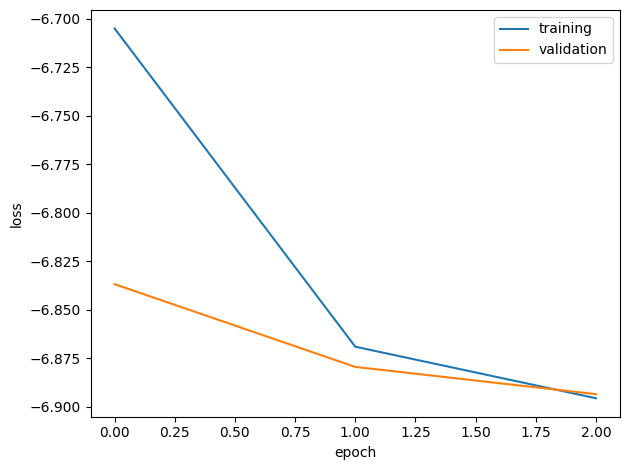

In [13]:
# after 5 epochs, training di

fig, ax = plt.subplots()
ax.plot(np.arange(len(model_snrv.training_losses)), model_snrv.training_losses)
ax.plot(np.arange(len(model_snrv.validation_losses)), model_snrv.validation_losses)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['training','validation'])
fig.tight_layout()

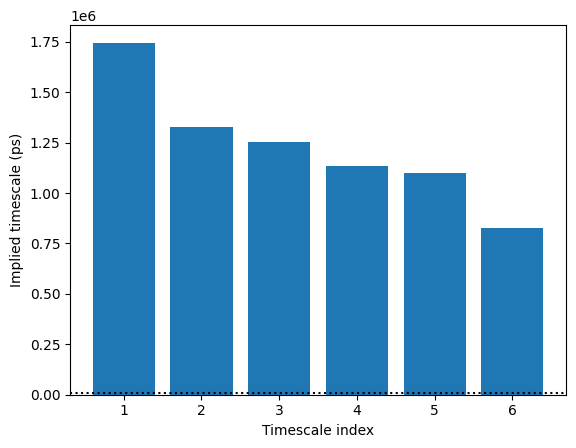

In [14]:
evals = model_snrv.evals.cpu().detach().numpy()
plt.bar(range(1, evals.size), -lag_n*save_freq/np.log(evals[1:]))  # by default use evals[1:]
plt.ylabel('Implied timescale (ps)')
plt.xticks(range(1, evals.size))
plt.xlabel('Timescale index')
plt.axhline(lag_n*save_freq, color='k', linestyle=':')

In [15]:
model_snrv.eval()

Snrv(
  (activation): GELU(approximate='none')
  (model): Sequential(
    (0): Linear(in_features=378, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=100, out_features=7, bias=True)
  )
)

In [16]:
evecs = model_snrv.transform(torch.cat(coords_torch)).cpu().detach().numpy()
print(evecs.shape)

(1000000, 7)


In [17]:
import deeptime as dt
tica = dt.decomposition.TICA(lagtime=5, dim=2)
TICs = tica.fit_transform([a.numpy() for a in coords_torch]).reshape(-1, 2)

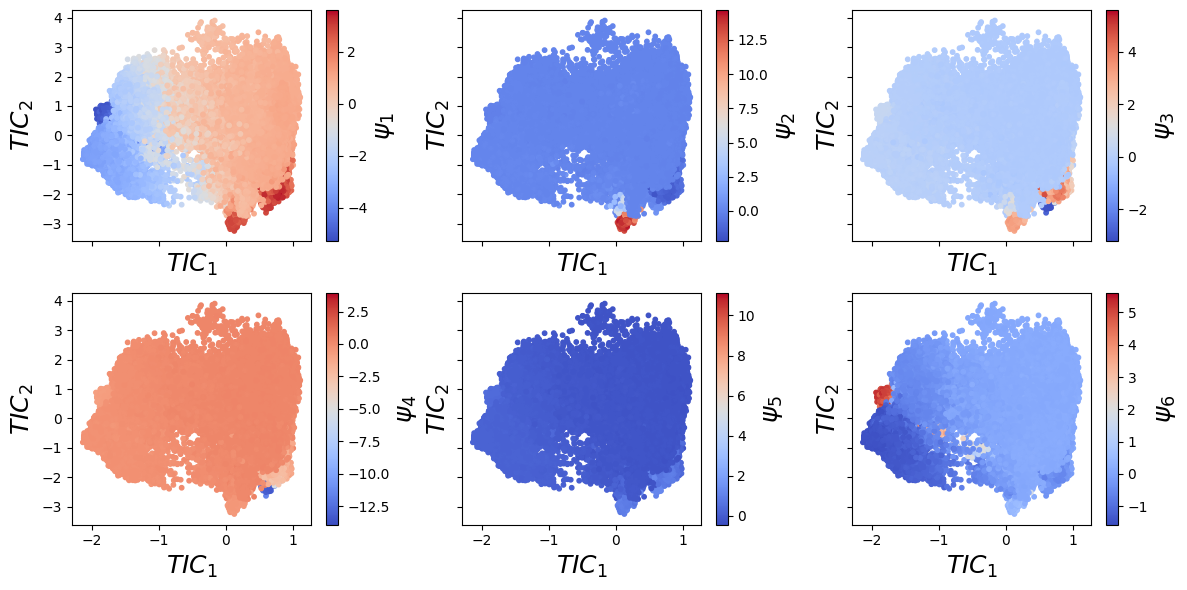

In [18]:
fig, axes = plt.subplots(2, 3, figsize = (12, 6), sharey=True, sharex=True)
axes = axes.flatten()
stride = 10

for e in range(1, evecs.shape[1]):
    evec = evecs[::stride, e]
    ax = axes[e-1]
    
    im = ax.scatter(TICs[::stride, 0], TICs[::stride, 1], c=evec, s=10, cmap='coolwarm')
    ax.set_xlabel('$TIC_1$', fontsize=18)
    ax.set_ylabel('$TIC_2$', fontsize=18)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(f'$\psi_{e}$', size=18)

plt.tight_layout()

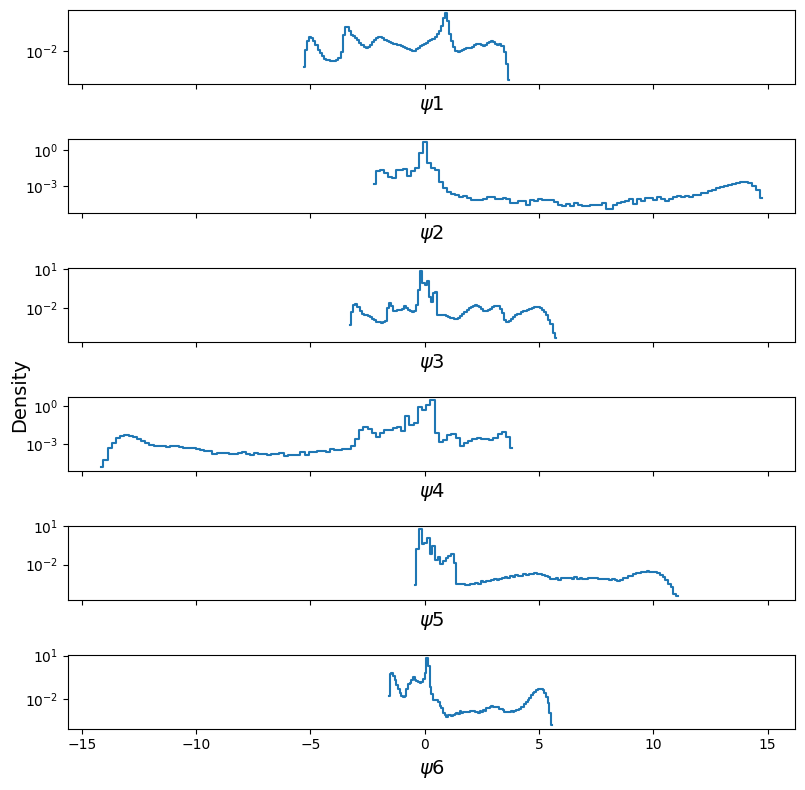

In [19]:
# check where transitions show up over trajectories

evec_idx = 4
nbins = 100
ntrjs = 10

fig, axes = plt.subplots(6, figsize=(8, 8), sharex=True)

for evec_idx, ax in enumerate(axes):
    bins = np.linspace(np.min(evecs[:, evec_idx+1]), np.max(evecs[:, evec_idx+1]), nbins)
    counts, bin_edges = np.histogram(evecs[:, evec_idx+1], bins=bins, density=True)
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    free_energy = -np.log(counts + 1e-10)
    
    #ax.plot(bin_centers, free_energy, drawstyle='steps-mid')
    ax.plot(bin_centers, counts, drawstyle='steps-mid')
    ax.set_xlabel(f'$\psi{evec_idx+1}$', fontsize=14)
    ax.set_yscale('log')
    
fig.text(0.0, 0.5, 'Density', va='center', rotation='vertical', fontsize=14)
plt.tight_layout()


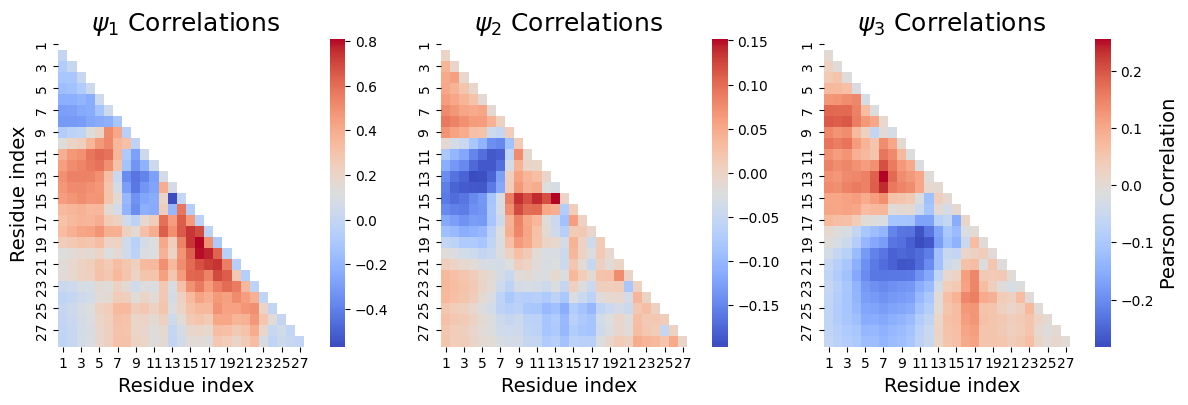

In [20]:
# Interpret models by checking correlations against input features (pairwise distances)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

all_feats = np.concatenate(coords_torch)
num_features = all_feats.shape[1]
nres = trjs[0].n_residues

for evec_idx, ax in enumerate(axes):

    heatmap = np.zeros((nres, nres))
    correlations = np.zeros(num_features)
    cnt = 0
    
    for i in range(num_features):
        correlations[i], _ = pearsonr(all_feats[:, i], evecs[:, evec_idx + 1])

    for i in range(len(heatmap)):
        for j in range(i+1, nres):
            heatmap[i, j] = correlations[cnt]
            heatmap[j, i] = correlations[cnt]
            cnt += 1

    mask = np.triu(np.ones_like(heatmap, dtype=bool))
    
    if evec_idx == 2:
            sns.heatmap(heatmap, mask=mask, cmap='coolwarm', ax=ax, 
                        cbar_kws={'label': 'Pearson Correlation'})
    else:
        sns.heatmap(heatmap, mask=mask, cmap='coolwarm', ax=ax)
        
    ax.set_title(f'$\psi_{evec_idx+1}$ Correlations', fontsize=18)
    ax.set_xlabel('Residue index', fontsize=14)
    
    ax.set_xticklabels(1 + 2*np.arange(14))
    ax.set_yticklabels(1 + 2*np.arange(14))
    
axes[0].set_ylabel('Residue index', fontsize=14)

cbar = ax.collections[-1].colorbar
cbar.set_label('Pearson Correlation', size=14)
cbar.ax.yaxis.label.set_size(14) 
    

In [41]:
v = nv.show_mdtraj(trjs[6])
v.clear_representations()
v.add_representation('ball+stick')
v

NGLWidget(max_frame=99999)

In [31]:
CVs = [model_snrv.transform(x).cpu().detach()[:, 1:] for x in coords_torch]
CVs_cat = torch.cat(CVs).numpy()
CVs[0].shape, len(CVs), CVs_cat.shape

(torch.Size([100000, 6]), 10, (1000000, 6))

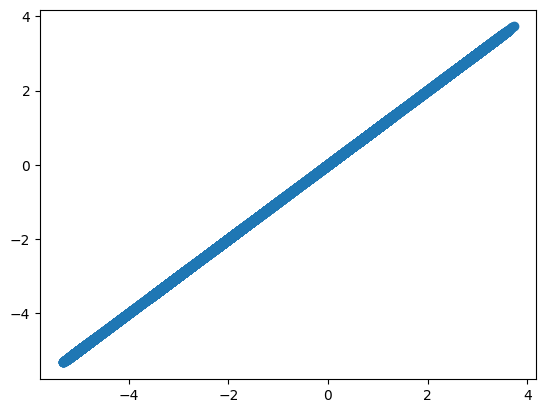

In [54]:
plt.scatter(CVs_cat[:, 0], evecs[:, 1])

# MDN propagator

In [25]:
model_mdn = Propagator(dim = CVs[0].size(1))

In [26]:
lag_mdn = 50   # set to same as SRV for now but this does not need to be the case

load_pretrained_mdn = True
save_new_model = False
model_save_path = './collab_files/model_mdn-100.pth'

if load_pretrained_mdn:
    model_mdn.load_state_dict(torch.load(model_save_path))
    model_mdn.is_fit = True
    
else:
    model_mdn.fit(CVs, lag = 10, max_epochs=100)
    if save_new_model:
        torch.save(model_mdn.state_dict(), model_save_path)


In [27]:
%%time

n_steps = 10 * len(CVs_cat) / lag_n

x = CVs[0][0][None]
synthetic_traj_CVs = model_mdn.gen_synthetic_traj(x, n_steps)
synthetic_traj_CVs.shape

  0%|          | 0/200000 [00:00<?, ?it/s]

CPU times: user 2min 19s, sys: 247 ms, total: 2min 19s
Wall time: 2min 22s


torch.Size([200000, 6])

Text(0.5, 0, 'Simulation Time (ms)')

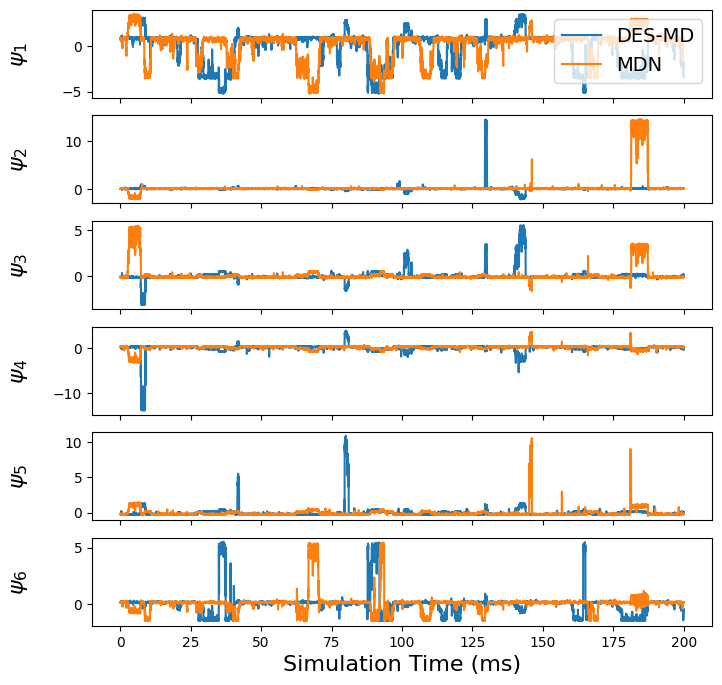

In [35]:
# compare plots of all evecs across time 

fig, axes = plt.subplots(6, figsize=(8, 8), sharex=True)

x = 0.01*np.arange(len(evecs)//lag_n)  # convert to ms
    
for evec_idx, ax in enumerate(axes):
    ax.plot(x, CVs_cat[::lag_n, evec_idx], label='DES-MD')
    ax.plot(x, synthetic_traj_CVs[:20_000, evec_idx], label='MDN')
    ax.set_ylabel(f'$\psi_{evec_idx+1}$', fontsize=16, labelpad=-20)
    ax.get_yaxis().set_label_coords(-0.1, 0.5)
    
#fig.subplots_adjust(left=0.1, hspace=0.3)
axes[0].legend(fontsize=14, loc='upper right')
axes[-1].set_xlabel('Simulation Time (ms)', fontsize=16)


/scratch/midway2/mikejones/conda_env/torchcfm_11.8/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/midway2/mikejones/conda_env/torchcfm_11.8/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/midway2/mikejones/conda_env/torchcfm_11.8/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/midway2/mikejones/conda_env/torchcfm_11.8/lib/python3.10/site-packages/seaborn/_ol

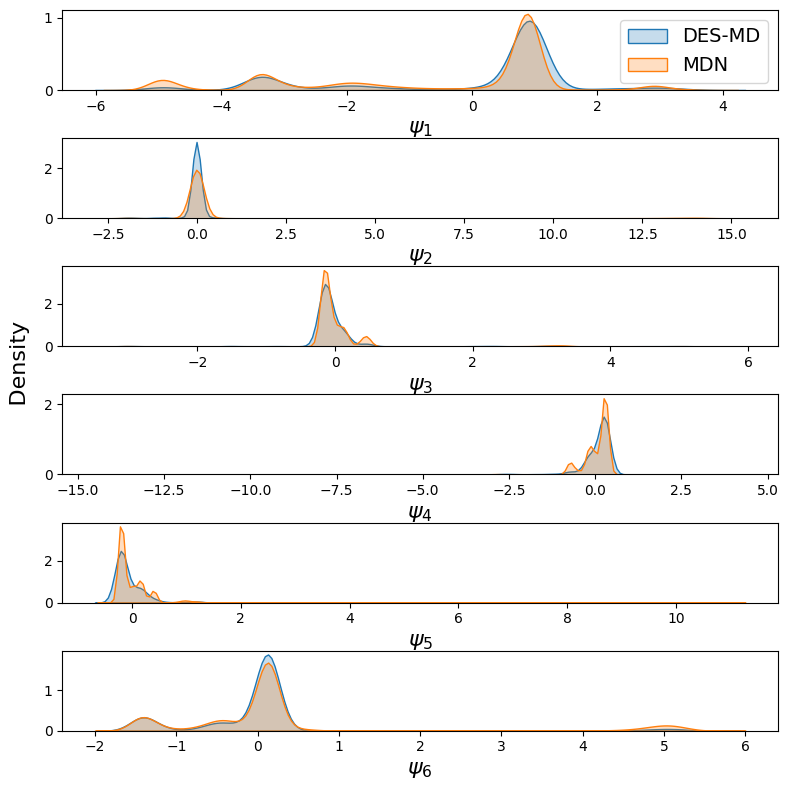

In [36]:
# histograms of all evecs across time -- ensures thermodynamics are approximately reproduced

fig, axes = plt.subplots(6, figsize=(8, 8), sharex=False)

evecs = np.array(evecs)
synthetic_traj_CVs = np.array(synthetic_traj_CVs)
evecs[np.isinf(evecs)] = np.nan
synthetic_traj_CVs[np.isinf(synthetic_traj_CVs)] = np.nan
    
for evec_idx, ax in enumerate(axes):
    sns.kdeplot(CVs_cat[::lag_n, evec_idx], ax=ax, label='DES-MD', fill=True)
    sns.kdeplot(synthetic_traj_CVs[:, evec_idx], ax=ax, label='MDN', fill=True)
    ax.set_ylabel('')
    ax.set_xlabel(f'$\psi_{evec_idx+1}$', fontsize=16)
    
axes[0].legend(fontsize=14)
axes[3].set_ylabel(' '*20 + 'Density', fontsize=16, labelpad=10)

plt.tight_layout()
plt.subplots_adjust(hspace=0.6)


# DDPM Decoder

In [37]:
# flatten coordiantes before passing to DDPM
# exclude the first 10_000 of each trj for testing

test_perc = 0.1
n_test = int(trjs[0].xyz.shape[0]*test_perc)
n_train = (trjs[0].xyz.shape[0] - n_test)

xyz_train = [torch.tensor(trj.xyz[n_test:].reshape(n_train, -1)).float() for trj in trjs]
CVs_train = [cv[n_test:] for cv in CVs]

xyz_test = [torch.tensor(trj.xyz[:n_test].reshape(n_test, -1)).float() for trj in trjs]
CVs_test = [cv[:n_test] for cv in CVs]

print(len(xyz_train), xyz_train[0].shape)
print(len(CVs_train), CVs_train[0].shape)

print(len(xyz_test), xyz_test[0].shape)
print(len(CVs_test), CVs_test[0].shape)

10 torch.Size([90000, 84])
10 torch.Size([90000, 6])
10 torch.Size([10000, 84])
10 torch.Size([10000, 6])


In [38]:
# uses 1000 steps by default, but 50-100 will be much faster and should work fine

n_timesteps = 100
n_epochs = 40
model_ddpm = DDPM(xyz_train[0].shape[1], CVs_train[0].shape[1], timesteps=n_timesteps)

In [39]:
%%time

load_pretrained_ddpm = True
save_new_model = False
model_save_path = f'./collab_files/model_ddpm-{n_epochs}-eps-{n_timesteps}-ts.pth'

if load_pretrained_ddpm:
    model_ddpm.load_state_dict(torch.load(model_save_path))
    model_ddpm.is_fit = True
    
else:
    model_ddpm.is_fit = False
    model_ddpm.fit(xyz_train, CVs_train, max_epochs=n_epochs)
    if save_new_model:
        torch.save(model_ddpm.state_dict(), model_save_path)

CPU times: user 52.1 ms, sys: 23 ms, total: 75.1 ms
Wall time: 399 ms


In [42]:
# Decode a set of real SRV coordinates first and check adherence to conditioning
# Decoding 10% of the total test set evenly strided (10_000 total)

trj_ref = md.join([trj[:10_000][::10] for trj in trjs])
CVs_ref = torch.Tensor(np.concatenate([cv[::10].numpy() for cv in CVs_test]))  #np.array([cv[0] for cv in CVs_test])

#trj_ref = md.join([trj[-1] for trj in trjs])
#CVs_ref = torch.Tensor([cv[-1].numpy() for cv in CVs_train])

print(CVs_ref.shape)

#print(np.shape(CVs_ref))

xyz_gen = model_ddpm.generate(torch.Tensor(CVs_ref))
xyz_gen = xyz_gen.reshape(xyz_gen.size(0), -1 , 3).numpy()

fake_trj = md.Trajectory(xyz = xyz_gen, topology=trjs[0].top)
fake_trj = md.join([ft.superpose(rf) for ft, rf in zip(fake_trj, trj_ref)])

torch.Size([10000, 6])


sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

In [43]:


rmsds_aligned = []
for f_gen, f_ref in zip(fake_trj, trj_ref):
    rmsds_aligned.append(md.rmsd(f_gen, f_ref)[0])
    
rmsds_random = []
rand_list = list(range(len(trj_ref)))
random.shuffle(rand_list)
for f_gen, f_ref in zip(fake_trj, [trj_ref[i] for i in rand_list]):
    rmsds_random.append(md.rmsd(f_gen, f_ref)[0])
    
print(len(rmsds_aligned), len(rmsds_random))

10000 10000


0.6564053
0.8625366


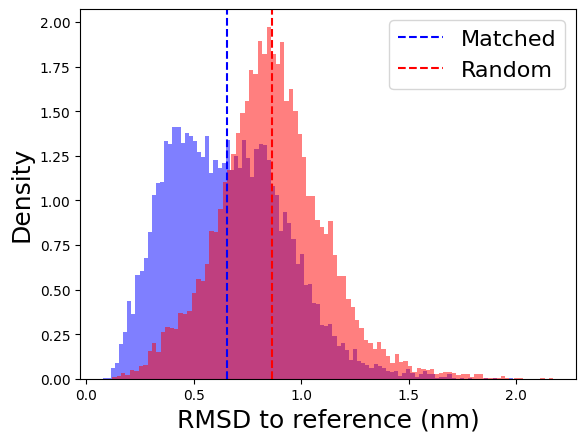

In [44]:
x = np.arange(len(rmsds_aligned))
plt.hist(rmsds_aligned, bins=100, alpha=0.5, color='blue', density=True)
plt.hist(rmsds_random, bins=100, alpha=0.5, color='red', density=True)

plt.axvline(np.mean(rmsds_aligned), linestyle='dashed', c='blue', label='Matched')
plt.axvline(np.mean(rmsds_random), linestyle='dashed', c='red', label='Random')

plt.legend(fontsize=16)
plt.xlabel('RMSD to reference (nm)', fontsize=18)
plt.ylabel('Density', fontsize=18)

print(np.mean(rmsds_aligned))
print(np.mean(rmsds_random))

# values 0.658, 0.856 for 100 diffusion steps

0.40817777777777775
(270000,)


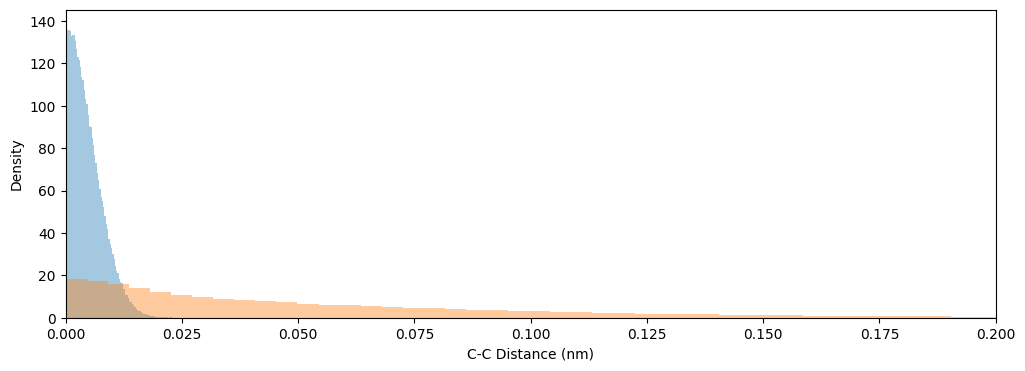

In [45]:
# get the rmsd

import pandas as pd

fig, axes = plt.subplots(figsize=(12, 4))

bonds = np.array([[i, i+1] for i in range(trj_ref.top.n_residues - 1)])
ref_dists = md.compute_distances(trj_ref, bonds)
gen_dists = md.compute_distances(fake_trj, bonds)

ref_dists = np.concatenate(ref_dists)
gen_dists = np.concatenate(gen_dists)

plt.hist(np.abs(ref_dists - np.mean(ref_dists)), bins=100, density=True, alpha=0.4)
plt.hist(np.abs(gen_dists - np.mean(ref_dists)), bins=100, density=True, alpha=0.4)

plt.axvline(np.mean(ref_dists), linestyle='dashed', c='blue', label='Matched')
plt.axvline(np.mean(gen_dists), linestyle='dashed', c='red', label='Random')

ref_min = np.min(ref_dists)
ref_max = np.max(ref_dists)

# Check if each element in gen_dists is between ref_min and ref_max
in_range = (ref_min < gen_dists) & (gen_dists < ref_max)

# Sum the number of elements in gen_dists that are in the specified range
num_in_range = np.sum(in_range)

# Calculate the proportion of elements in the specified range
proportion_in_range = num_in_range / np.prod(gen_dists.shape)
print(proportion_in_range)

plt.xlim(0, 0.2)
plt.xlabel('C-C Distance (nm)')
plt.ylabel('Density')

print(ref_dists.shape)



In [46]:
v = nv.show_mdtraj(trj_ref)
v.add_trajectory(fake_trj)

v[0].clear_representations()
v[0].add_representation('ball+stick', color='blue')

v[1].clear_representations()
v[1].add_representation('ball+stick', color='red')
v

NGLWidget(max_frame=9999)

/home/mikejones/ipykernel_3195137/2339864473.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for colorbar


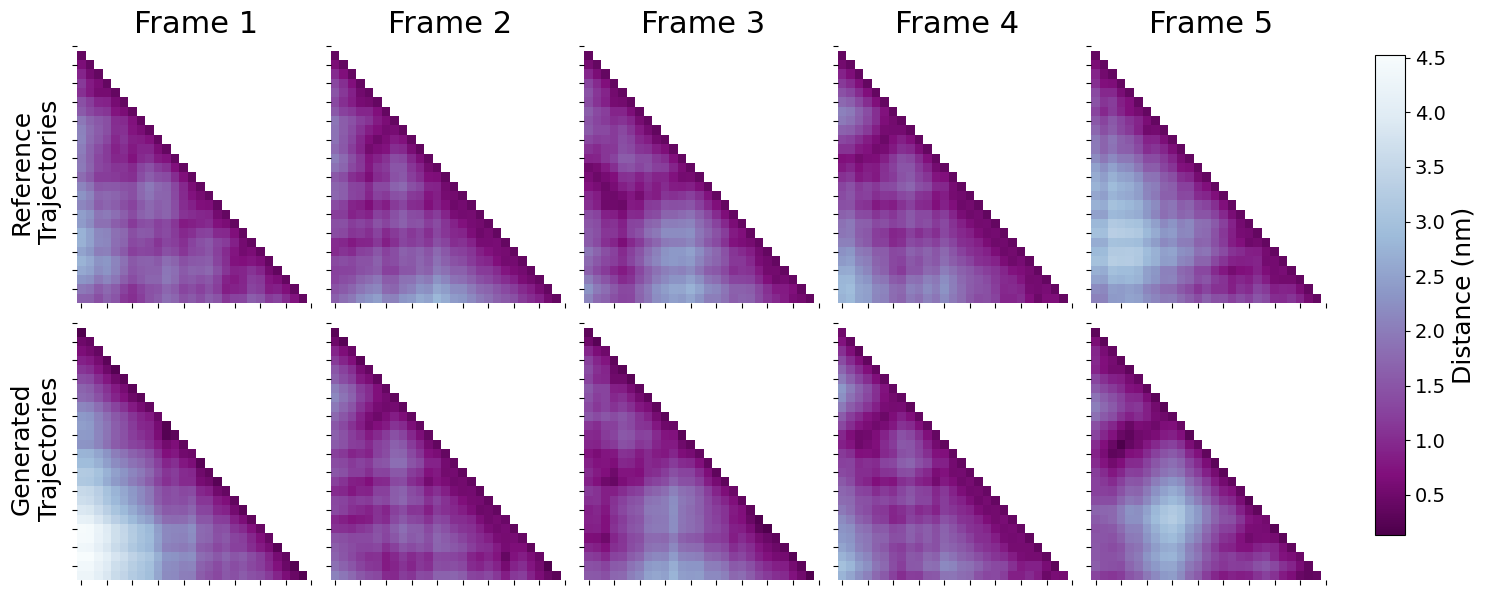

In [47]:
# calculate pairwise distances between each ref and gen structure
# we should observe similar profiles between the top row and bottom row plots

pdists_ref = [torch.pdist(p)[None] for p in torch.tensor(trj_ref.xyz[4::2000])]
pdists_gen = [torch.pdist(p)[None] for p in torch.tensor(fake_trj.xyz[4::2000])]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

cmap = 'BuPu_r'

global_min = np.inf
global_max = -np.inf

for p_ref, p_gen in zip(pdists_ref, pdists_gen):
    global_min = min(global_min, p_ref.min(), p_gen.min())
    global_max = max(global_max, p_ref.max(), p_gen.max())

# Create heatmaps
for f, (p_ref, p_gen, ax_row) in enumerate(zip(pdists_ref, pdists_gen, axes.T)):
    heatmap_ref = np.zeros((nres, nres))
    heatmap_gen = np.zeros((nres, nres))

    cnt = 0
    for i in range(len(heatmap_ref)):
        for j in range(i + 1, nres):
            heatmap_ref[j, i] = p_ref[0, cnt]
            heatmap_gen[j, i] = p_gen[0, cnt]
            cnt += 1

    mask = np.triu(np.ones_like(heatmap_ref, dtype=bool))
    sns.heatmap(heatmap_ref, mask=mask, cmap=cmap, ax=ax_row[0], cbar=False, vmin=global_min, vmax=global_max)
    sns.heatmap(heatmap_gen, mask=mask, cmap=cmap, ax=ax_row[1], cbar=False, vmin=global_min, vmax=global_max)
    ax_row[0].set_title(f'Frame {f+1}', fontsize=22)

# Add the shared colorbar
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Position for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=global_min, vmax=global_max))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, label='Distance (nm)')

for ax in axes.flatten():
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
# Increase tick size and font size
cbar.ax.tick_params(labelsize=14)  # Set the tick label size
cbar.ax.yaxis.label.set_size(18)   # Set the colorbar label font size

axes[0, 0].set_ylabel('Reference\nTrajectories', fontsize=18)
axes[1, 0].set_ylabel('Generated\nTrajectories', fontsize=18)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for colorbar
plt.show()


# Decode synthetic traj

In [48]:
xyz_gen = model_ddpm.generate(torch.Tensor(synthetic_traj_CVs[:1000]))

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

In [49]:
xyz_gen = xyz_gen.reshape(xyz_gen.size(0), -1 , 3).numpy()
fake_trj = md.Trajectory(xyz = xyz_gen, topology=trjs[0].top)

In [50]:
# decode first frame of each traj (each has different embeddings)

xyz_ref = [trj.xyz for trj in trjs]
evec_ref = evecs[:10]

# Visualize results

In [51]:
import nglview as nv

In [52]:
v = nv.show_mdtraj(fake_trj)
v.clear_representations()
v.add_representation('ball+stick')
v

NGLWidget(max_frame=999)

In [34]:
#fake_trj.save_pdb('BBA_Ca_synthetic_traj.pdb')